<a href="https://colab.research.google.com/github/tomasdevelopment/PuckInsights/blob/main/notebooks/sportsstatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
#Exploratory analysis
import pandas as pd

# ------------------------------------------------------------------ #
# 0.  Load raw data                                                  #
# ------------------------------------------------------------------ #
FILE_PATH = "/content/drive/My Drive/sportsanalytics/nhldraft.csv"
hockey_df = pd.read_csv(FILE_PATH)

# ------------------------------------------------------------------ #
# 1.  Clean function (must exist BEFORE using it)                    #
# ------------------------------------------------------------------ #
def clean_hockey_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()         # Clean column names
    df.dropna(how='all', inplace=True)          # Drop empty rows
    df = df[df['points']>0]

    # Make sure 'points' exists and is numeric, then fill NaNs
    if 'points' in df.columns:
        df['points'] = pd.to_numeric(df['points'], errors='coerce').fillna(0).astype(int)
    else:
        raise KeyError("'points' column not found in DataFrame")
    return df

# ------------------------------------------------------------------ #
# 2.  Clean, but DO NOT overwrite the function!                      #
# ------------------------------------------------------------------ #
hockey_clean = clean_hockey_df(hockey_df)   # ← keep object & function distinct

# ------------------------------------------------------------------ #
# 3.  One-liner footprint helper                                     #
# ------------------------------------------------------------------ #
def footprint(df: pd.DataFrame) -> dict:
    """Return shape & memory stats for any DataFrame."""
    mem_bytes = df.memory_usage(deep=True).sum()
    return {
        "rows"          : len(df),
        "cols"          : df.shape[1],
        "memory_MB"     : round(mem_bytes / 1024 ** 2, 3),
        "bytes_per_row" : round(mem_bytes / len(df), 1) if len(df) else 0,
        "min_year": df.year.min(),
        "max_year": df.year.max(),
    }

print("After cleaning:")
for k, v in footprint(hockey_clean).items():
    print(f"  {k:>13}: {v}")

# ------------------------------------------------------------------ #
# 4.  Optional peek                                                  #
# ------------------------------------------------------------------ #
print(hockey_clean.head())
hockey_clean.columns

After cleaning:
           rows: 4514
           cols: 23
      memory_MB: 2.123
  bytes_per_row: 493.1
       min_year: 1963
       max_year: 2021
      id  year  overall_pick                   team           player  \
225  226  2021             1         Buffalo Sabres       Owen Power   
226  227  2021             2         Seattle Kraken  Matthew Beniers   
227  228  2021             3          Anaheim Ducks   Mason Mctavish   
229  230  2021             5  Columbus Blue Jackets     Kent Johnson   
231  232  2021             7        San Jose Sharks   William Eklund   

    nationality position   age  to_year              amateur_team  ...  \
225          CA        D  18.0   2022.0        Michigan (Big Ten)  ...   
226          US        C  18.0   2022.0        Michigan (Big Ten)  ...   
227          CH        C  18.0   2022.0  Peterborough Petes (OHL)  ...   
229          CA        C  18.0   2022.0        Michigan (Big Ten)  ...   
231          SE       LW  18.0   2022.0   Djurgar

Index(['id', 'year', 'overall_pick', 'team', 'player', 'nationality',
       'position', 'age', 'to_year', 'amateur_team', 'games_played', 'goals',
       'assists', 'points', 'plus_minus', 'penalties_minutes',
       'goalie_games_played', 'goalie_wins', 'goalie_losses',
       'goalie_ties_overtime', 'save_percentage', 'goals_against_average',
       'point_shares'],
      dtype='object')

In [3]:
#Exploratory analysis One
import pandas as pd
from scipy import stats
from typing import Dict, List, Tuple

# --------------------------------------------------------------------------- #
# 1.  Cleaning layer (unchanged from last fix)                                #
# --------------------------------------------------------------------------- #
def clean_hockey_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    df.dropna(how='all', inplace=True)

    # points → numeric, NaN→0, cast to int
    if 'points' not in df.columns:
        raise KeyError("'points' column not found")
    df['points'] = (
        pd.to_numeric(df['points'], errors='coerce')
        .fillna(0)
        .astype(int)
    )
    return df


# --------------------------------------------------------------------------- #
# 2A.  Summary-only helper                                                    #
# --------------------------------------------------------------------------- #
def points_summary(
    pts: pd.Series, *, trim_prop: float = 0.10
) -> Dict[str, float | int]:
    """
    Return location & dispersion stats for a points Series.
    """
    q1, q3 = pts.quantile([0.25, 0.75])
    iqr = q3 - q1
    return {
        "count"        : int(pts.count()),
        "mean"         : float(pts.mean()),
        "median"       : int(pts.median()),
        "trimmed_mean" : float(stats.trim_mean(pts, trim_prop)),
        "mad"          : float(stats.median_abs_deviation(pts, scale="normal")),
        "variance"     : float(pts.var()),
        "std_dev"      : float(pts.std()),
        "iqr"          : int(iqr),
        "lower_bound"  : int(q1 - 1.5 * iqr),
        "upper_bound"  : int(q3 + 1.5 * iqr),
    }


# --------------------------------------------------------------------------- #
# 2B.  Group-slices helper                                                    #
# --------------------------------------------------------------------------- #
def points_groups(
    df_clean: pd.DataFrame,
    summary: Dict[str, float | int],
) -> Dict[str, List[dict]]:
    """
    Return dict of interesting player slices, already sorted.
    """
    pts = df_clean["points"]

    def keep_cols(df: pd.DataFrame) -> List[dict]:
        return df[["year", "player", "team", "points"]].to_dict("records")

    upper = df_clean[pts >= summary["upper_bound"]]\
            .sort_values(["year", "points"], ascending=False)

    lower = df_clean[pts <= summary["lower_bound"]]\
            .sort_values(["points", "year"], ascending=True)

    max_pts, min_pts = int(pts.max()), int(pts.min())

    return {
        "upper_players"   : keep_cols(upper),
        "lower_players"   : keep_cols(lower),
        "top_players"     : keep_cols(df_clean[pts == max_pts]),
        "bottom_players"  : keep_cols(df_clean[pts == min_pts]),
        "bottom_nonzero"  : keep_cols(df_clean[pts == pts[pts != 0].min()])
                            if (pts != 0).any() else [],
    }


# --------------------------------------------------------------------------- #
# 3.  Public façade — returns *two* objects                                   #
# --------------------------------------------------------------------------- #
def hockey_overview(
    df: pd.DataFrame, *, trim_prop: float = 0.10
) -> Tuple[Dict[str, float | int], Dict[str, List[dict]]]:
    """
    High-level wrapper that returns (summary, groups).
    """
    df_clean = clean_hockey_df(df)
    pts      = df_clean["points"]
    summary  = points_summary(pts, trim_prop=trim_prop)
    groups   = points_groups(df_clean, summary)
    return summary, groups


# --------------------------------------------------------------------------- #
# Example usage                                                               #
# --------------------------------------------------------------------------- #
FILE_PATH = "/content/drive/My Drive/sportsanalytics/nhldraft.csv"
raw_df     = pd.read_csv(FILE_PATH)

summary_dict, groups_dict = hockey_overview(hockey_clean)

print("== Location & dispersion statistics ==")
for k, v in summary_dict.items():
    print(f"{k:>14}: {v}")

print("\n== Upper-outlier players ==")
for rec in groups_dict["upper_players"][:5]:  # show first 5 only
    print(rec)




== Location & dispersion statistics ==
         count: 4514
          mean: 157.93376163048293
        median: 48
  trimmed_mean: 102.58997785160575
           mad: 68.19970205125769
      variance: 59516.908751324765
       std_dev: 243.96087545203793
           iqr: 198
   lower_bound: -289
   upper_bound: 503

== Upper-outlier players ==
{'year': 2015, 'player': 'Connor McDavid', 'team': 'Edmonton Oilers', 'points': 697}
{'year': 2014, 'player': 'Leon Draisaitl', 'team': 'Edmonton Oilers', 'points': 616}
{'year': 2014, 'player': 'David Pastrnak', 'team': 'Boston Bruins', 'points': 504}
{'year': 2013, 'player': 'Nathan MacKinnon', 'team': 'Colorado Avalanche', 'points': 648}
{'year': 2013, 'player': 'Aleksander Barkov', 'team': 'Florida Panthers', 'points': 553}


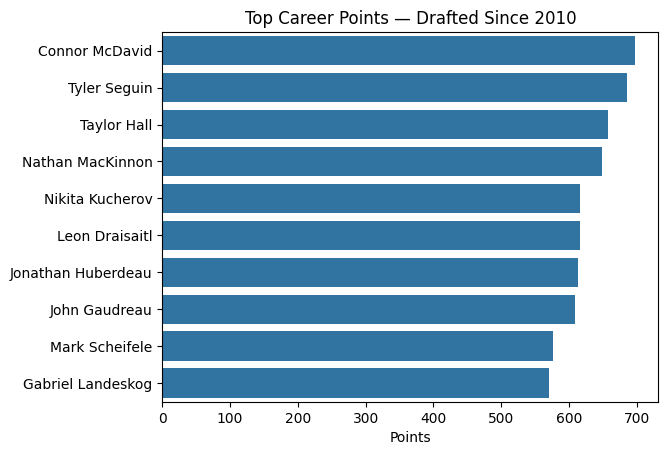

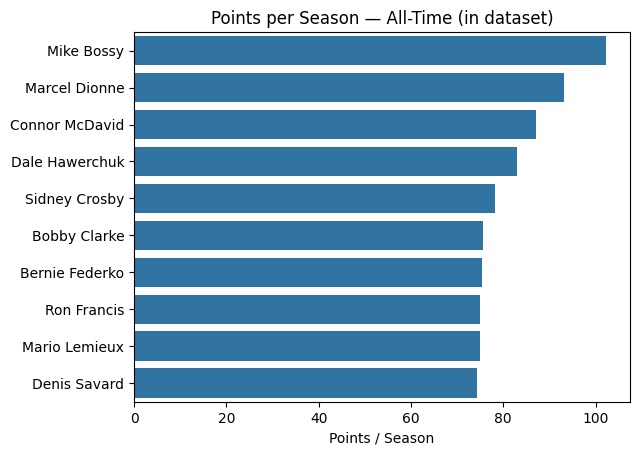

In [4]:
#Mcdavid Analytics
# Filter recent draft years
recent_players = hockey_clean[hockey_clean["year"] >= 2010].copy()

# Sort by career points in dataset
top_recent = recent_players.sort_values("points", ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top_recent, x="points", y="player")
plt.title("Top Career Points — Drafted Since 2010")
plt.xlabel("Points")
plt.ylabel("")
plt.show()


hockey_clean["years_played"] = hockey_clean["to_year"] - hockey_clean["year"] + 1
hockey_clean["points_per_season"] = hockey_clean["points"] / hockey_clean["years_played"]

top_rate = (
    hockey_clean[hockey_clean["points"] > 0]
    .sort_values("points_per_season", ascending=False)
    .head(10)
)

sns.barplot(data=top_rate, x="points_per_season", y="player")
plt.title("Points per Season — All-Time (in dataset)")
plt.xlabel("Points / Season")
plt.ylabel("")
plt.show()




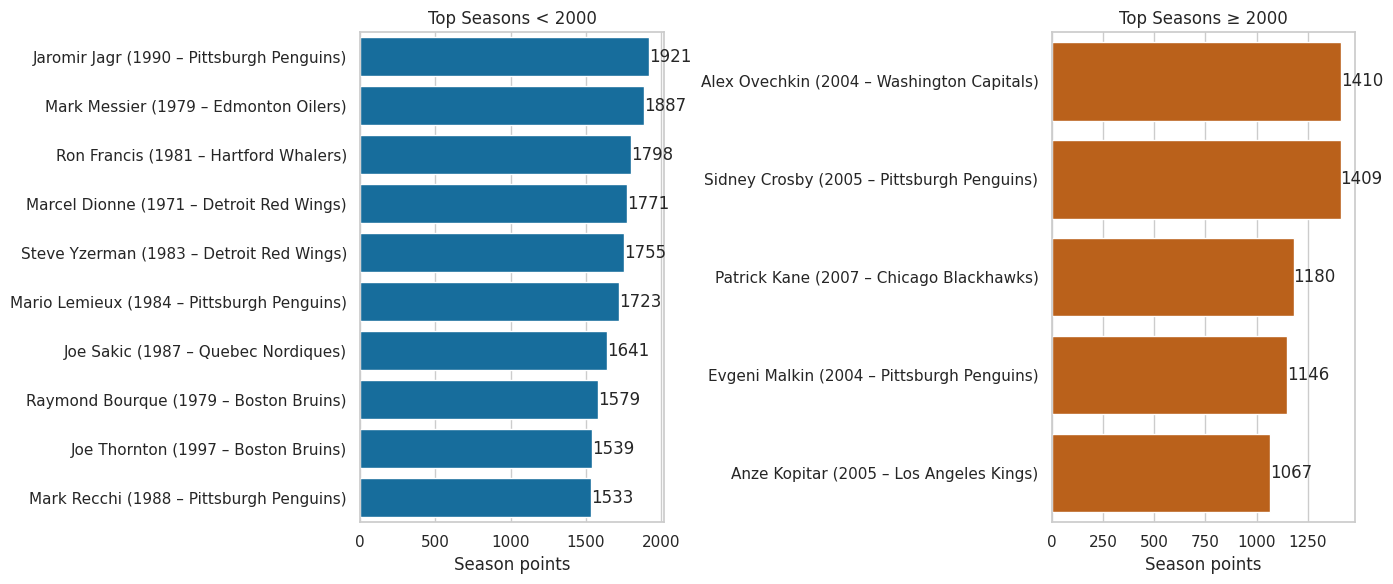

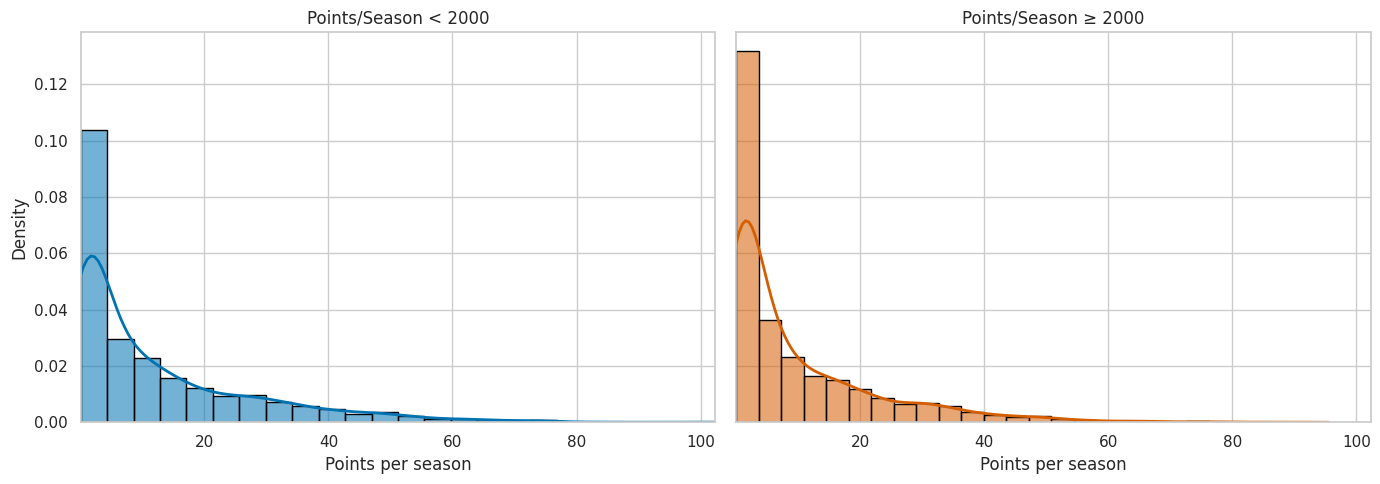

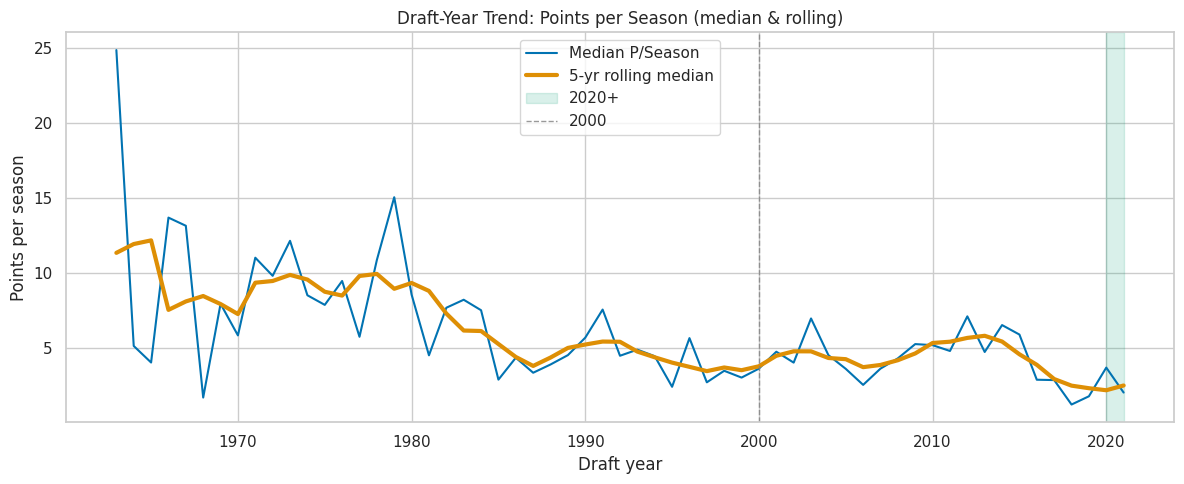

/tmp/ipython-input-3056839563.py:143: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(roll_median_pps=g["median_pps"]


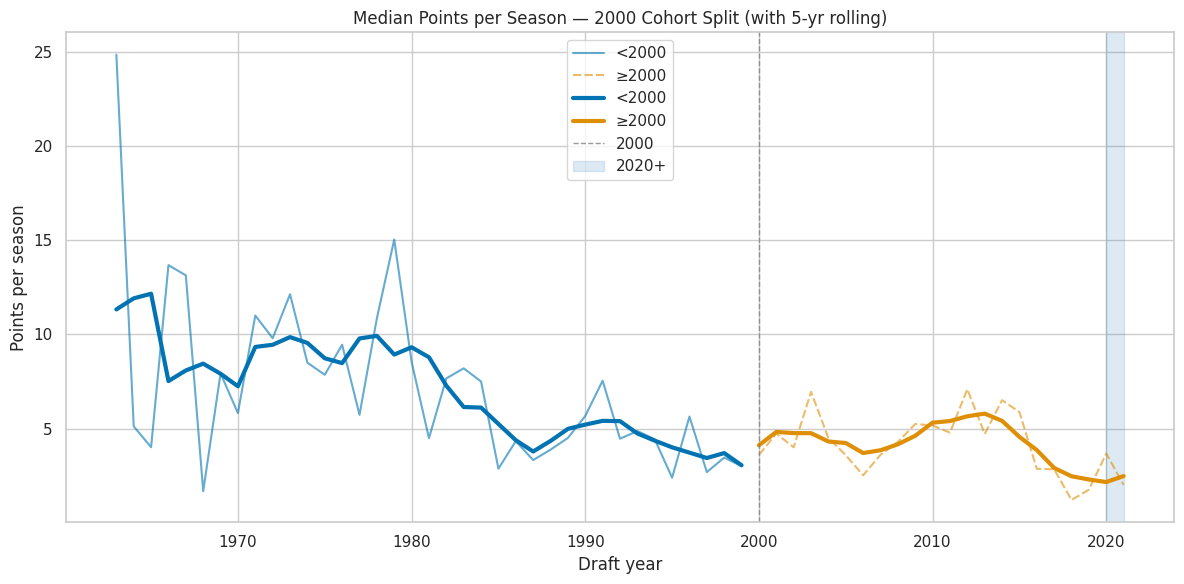

/tmp/ipython-input-3056839563.py:172: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(y=g["median_pps"]


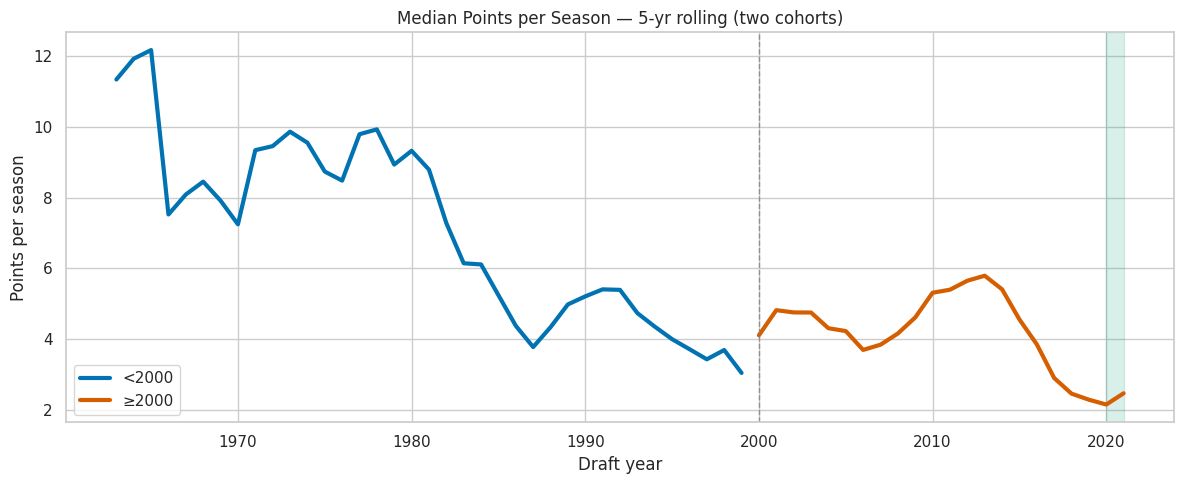


== Cohort stats (rate metric) ==
cohort  mean_points_per_season  median_points_per_season  mean_points  median_points    n
 <2000                   12.32                      6.11       183.21           60.0 2691
 ≥2000                    9.71                      4.20       120.62           37.0 1823

== Era table (decade buckets; rate metric) ==
      era  mean_pps  median_pps  players
    1960s     13.76        8.75       81
    1970s     16.04        9.60      696
    1980s     11.95        5.70      949
    1990s      9.87        4.10      965
    2000s      9.98        4.29      967
    2010s      9.47        4.12      831
2020–2021      6.96        3.67       25


In [5]:
#Season comparison analytics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Setup: consistent, colorblind-safe theme ----------
sns.set_theme(style="whitegrid", palette="colorblind")
PRE_COLOR, POST_COLOR, FOCUS_2020 = sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2]

def ensure_points_per_season(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["points"] = pd.to_numeric(out["points"], errors="coerce")
    out["year"]   = pd.to_numeric(out["year"], errors="coerce")
    out["to_year"] = pd.to_numeric(out.get("to_year", np.nan), errors="coerce")
    out = out.dropna(subset=["points","year"])

    # Conservative handling: if to_year is NaN, treat it as the draft year → years_played = 1
    end_year = out["to_year"].fillna(out["year"])
    years_played = (end_year - out["year"] + 1).clip(lower=1)
    out["years_played"] = years_played
    out["points_per_season"] = out["points"] / out["years_played"]
    return out

def season_comparison_enhanced(
    df: pd.DataFrame,
    *,
    cutoff_year: int = 2000,
    top_before: int = 10,
    top_after: int = 5,
    bins: int = 24,
    roll: int = 5
):
    d = ensure_points_per_season(df)
    req = {"year","player","team","points","points_per_season"}
    miss = req - set(d.columns)
    if miss:
        raise KeyError(f"Missing columns: {miss}")

    pre  = d[d["year"] <  cutoff_year].copy()
    post = d[d["year"] >= cutoff_year].copy()

    # ====== stats table for cohorts (rate metric) ======
    stats = (
        pd.concat([pre.assign(cohort=f"<{cutoff_year}"),
                   post.assign(cohort=f"≥{cutoff_year}")])
          .groupby("cohort")
          .agg(mean_points_per_season=("points_per_season","mean"),
               median_points_per_season=("points_per_season","median"),
               mean_points=("points","mean"),
               median_points=("points","median"),
               n=("points","count"))
          .round(2)
          .reset_index()
    )

    # ====== era (decade) table on rate metric ======
    # eras: 1960s, 1970s, ..., 2020–2022 (or to your max year)
    max_year = int(d["year"].max())
    bins_ = [1963, 1969, 1979, 1989, 1999, 2009, 2019, max_year]
    labels_ = ["1960s","1970s","1980s","1990s","2000s","2010s",f"2020–{max_year}"]
    era_table = (
        d.assign(era=pd.cut(d["year"], bins=bins_, labels=labels_, include_lowest=True, right=True))
         .groupby("era", observed=True)
         .agg(mean_pps=("points_per_season","mean"),
              median_pps=("points_per_season","median"),
              players=("player","count"))
         .round(2)
         .reset_index()
    )

    # ====== Top seasons bars (colors cleaned up) ======
    top_pre  = pre.sort_values("points", ascending=False).head(top_before)
    top_post = post.sort_values("points", ascending=False).head(top_after)
    top_pre["label"]  = top_pre.apply(lambda r: f"{r.player} ({int(r.year)} – {r.team})", axis=1)
    top_post["label"] = top_post.apply(lambda r: f"{r.player} ({int(r.year)} – {r.team})", axis=1)

    fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)
    sns.barplot(data=top_pre,  x="points", y="label", ax=axes1[0], color=PRE_COLOR)
    axes1[0].set_title(f"Top Seasons < {cutoff_year}")
    axes1[0].set_xlabel("Season points"); axes1[0].set_ylabel("")
    for c in axes1[0].containers: axes1[0].bar_label(c, fmt="%.0f")

    sns.barplot(data=top_post, x="points", y="label", ax=axes1[1], color=POST_COLOR)
    axes1[1].set_title(f"Top Seasons ≥ {cutoff_year}")
    axes1[1].set_xlabel("Season points"); axes1[1].set_ylabel("")
    for c in axes1[1].containers: axes1[1].bar_label(c, fmt="%.0f")
    fig1.tight_layout()
    plt.show()

    # ====== Distributions (use rate metric; comparable across eras) ======
    xmin = d["points_per_season"].min(); xmax = d["points_per_season"].max()
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

    sns.histplot(pre["points_per_season"], bins=bins, stat="density", ax=axes2[0], alpha=.55, color=PRE_COLOR, edgecolor="black")
    sns.kdeplot(pre["points_per_season"], ax=axes2[0], lw=2, color=PRE_COLOR)
    axes2[0].set_title(f"Points/Season < {cutoff_year}"); axes2[0].set_xlim(xmin, xmax); axes2[0].set_xlabel("Points per season"); axes2[0].set_ylabel("Density")

    sns.histplot(post["points_per_season"], bins=bins, stat="density", ax=axes2[1], alpha=.55, color=POST_COLOR, edgecolor="black")
    sns.kdeplot(post["points_per_season"], ax=axes2[1], lw=2, color=POST_COLOR)
    axes2[1].set_title(f"Points/Season ≥ {cutoff_year}"); axes2[1].set_xlim(xmin, xmax); axes2[1].set_xlabel("Points per season"); axes2[1].set_ylabel("")
    fig2.tight_layout()
    plt.show()

    # ====== NEW: by-draft-year trend on points_per_season ======
    yearly = (
        d.groupby("year", as_index=False)
         .agg(median_pps=("points_per_season","median"),
              mean_pps=("points_per_season","mean"),
              n=("player","count"))
         .sort_values("year")
    )
    yearly["roll_median_pps"] = yearly["median_pps"].rolling(roll, min_periods=1, center=True).mean()

    fig3, ax3 = plt.subplots(figsize=(12, 5))
    sns.lineplot(data=yearly, x="year", y="median_pps", ax=ax3, lw=1.5, label="Median P/Season")
    sns.lineplot(data=yearly, x="year", y="roll_median_pps", ax=ax3, lw=3, label=f"{roll}-yr rolling median")

    # highlight ≥2020 for emphasis
    ax3.axvspan(2020, yearly["year"].max(), alpha=.15, color=FOCUS_2020, label="2020+")
    ax3.axvline(cutoff_year, ls="--", lw=1, color="gray", alpha=.8, label=f"{cutoff_year}")
    ax3.set_title("Draft-Year Trend: Points per Season (median & rolling)")
    ax3.set_xlabel("Draft year"); ax3.set_ylabel("Points per season")
    ax3.legend()
    plt.tight_layout()
    plt.show()

    return {"cohort_stats": stats, "era_table": era_table, "yearly_trend": yearly}
def season_median_comparison(df, cutoff_year=2000, roll=5):
    d = ensure_points_per_season(df)

    yearly = (
        d.groupby("year", as_index=False)
         .agg(median_pps=("points_per_season","median"))
    )

    # Split into pre/post cohorts for separate medians
    yearly["cohort"] = np.where(yearly["year"] < cutoff_year, f"<{cutoff_year}", f"≥{cutoff_year}")

    # Rolling medians per cohort
    rolled = (
        yearly.groupby("cohort", group_keys=False)
              .apply(lambda g: g.assign(roll_median_pps=g["median_pps"]
                                        .rolling(roll, min_periods=1, center=True).mean()))
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=rolled, x="year", y="median_pps", hue="cohort", lw=1.5, style="cohort", alpha=0.6)
    sns.lineplot(data=rolled, x="year", y="roll_median_pps", hue="cohort", lw=3)

    plt.axvline(cutoff_year, ls="--", lw=1, color="gray", alpha=.8, label=f"{cutoff_year}")
    plt.axvspan(2020, rolled["year"].max(), alpha=.15, color="tab:blue", label="2020+")
    plt.title(f"Median Points per Season — {cutoff_year} Cohort Split (with {roll}-yr rolling)")
    plt.xlabel("Draft year")
    plt.ylabel("Points per season")
    plt.legend()
    plt.tight_layout()
    plt.show()

def season_median_two_lines(df, cutoff_year=2000, roll=5):
    d = ensure_points_per_season(df)

    yearly = (
        d.groupby("year", as_index=False)
         .agg(median_pps=("points_per_season", "median"))
    )
    yearly["cohort"] = np.where(yearly["year"] < cutoff_year,
                                f"<{cutoff_year}", f"≥{cutoff_year}")

    # one series per cohort: rolling median only
    rolled = (yearly.groupby("cohort", group_keys=False)
                    .apply(lambda g: g.assign(y=g["median_pps"]
                                              .rolling(roll, min_periods=1, center=True).mean())))

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=rolled, x="year", y="y", hue="cohort",
                 lw=3, palette=[PRE_COLOR, POST_COLOR])
    plt.axvline(cutoff_year, ls="--", lw=1, color="gray", alpha=.8)
    plt.axvspan(2020, rolled["year"].max(), alpha=.15, color=FOCUS_2020)
    plt.title(f"Median Points per Season — {roll}-yr rolling (two cohorts)")
    plt.xlabel("Draft year"); plt.ylabel("Points per season")
    plt.legend(title="")
    plt.tight_layout(); plt.show()

# ---------- Run ----------
res = season_comparison_enhanced(hockey_clean, cutoff_year=2000, top_before=10, top_after=5, bins=24, roll=5)
season_median_comparison(hockey_clean)
season_median_two_lines(hockey_clean)
# View the tables
print("\n== Cohort stats (rate metric) ==")
print(res["cohort_stats"].to_string(index=False))

print("\n== Era table (decade buckets; rate metric) ==")
print(res["era_table"].to_string(index=False))


/tmp/ipython-input-2645376556.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


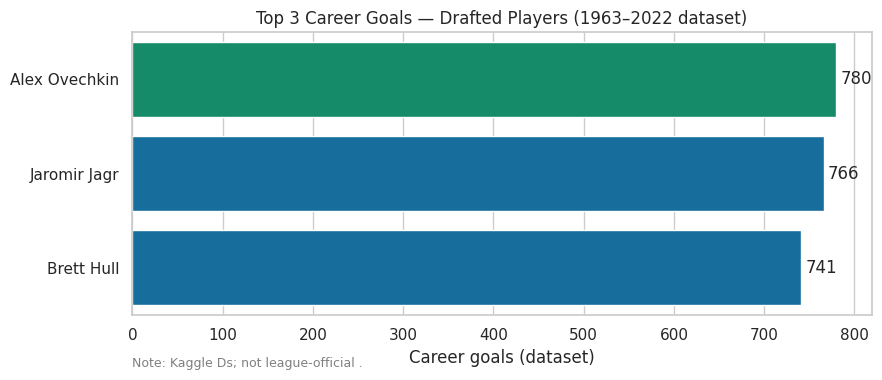

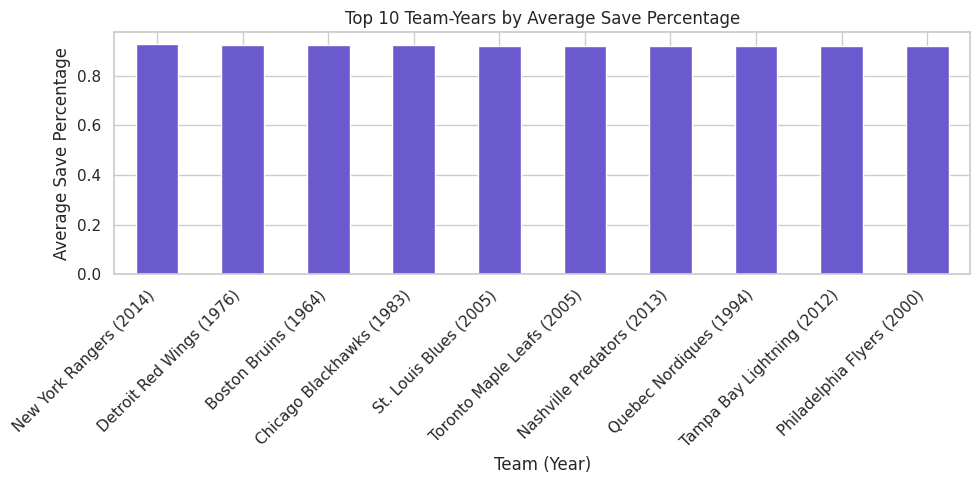

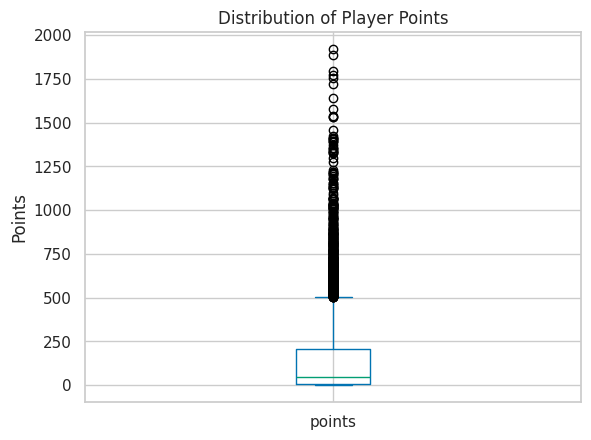

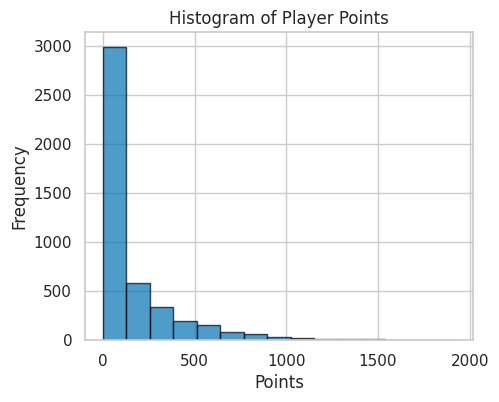

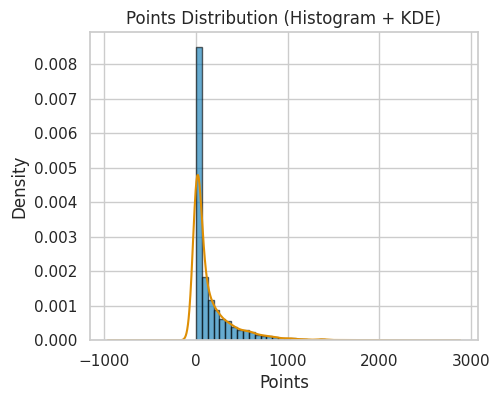

<Axes: title={'center': 'Points Distribution (Histogram + KDE)'}, xlabel='Points', ylabel='Density'>

In [ ]:
#exploratory analysis analytics
import matplotlib.pyplot as plt
import pandas as pd      # ←-- make sure this is imported if you call binned_points_distribution

# ──────────────────────────────────────────────────────────────────────────────
# ▶ BOTH (location + spread)  — quantiles include the median (center) and tails
def points_percentiles(df, col='points', percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Returns specified percentiles for the points column in the DataFrame.

    Statistic type
    --------------
    • 5-th/25-th/75-th/95-th  → spread
    • 50-th (median)         → location
    """
    return df[col].quantile(percentiles)

# ──────────────────────────────────────────────────────────────────────────────
# ▶ BOTH (location + spread)  — median line = location, box/IQR & whiskers = spread
def plot_points_box(df, col='points', title='Distribution of Player Points'):
    """
    Plots a box plot for the points column.

    Statistic type
    --------------
    • Median line            → location
    • IQR & whiskers         → spread
    """
    ax = df[col].plot.box()
    ax.set_ylabel('Points')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — shape/width show dispersion; center is secondary
def plot_points_hist(df, col='points', bins=15, title='Histogram of Player Points'):
    """
    Plots a histogram for the points column.

    Statistic type
    --------------
    • Bar width & silhouette → spread (variance, skew)
    """
    ax = df[col].plot.hist(bins=bins, figsize=(5, 4),
                           alpha=0.7, edgecolor='black')
    ax.set_xlabel('Points')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — same information as a histogram but returned as counts per bin
def binned_points_distribution(df, col='points', bins=10):
    """
    Returns value counts for points binned into intervals.

    Statistic type
    --------------
    • Count per interval     → spread (distribution profile)
    """
    binned = pd.cut(df[col], bins=bins)
    return binned.value_counts().sort_index()

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — histogram + smooth KDE visualise dispersion/shape
def plot_points_hist_kde(df, col='points', bins=30,
                         title='Points Distribution (Histogram + KDE)'):
    """
    Plots a histogram with density=True and overlays a KDE for the points column.

    Statistic type
    --------------
    • Histogram & KDE curve  → spread (variance, multimodality, tails)
    """
    ax = df[col].plot.hist(density=True, bins=bins,
                           alpha=0.6, edgecolor='black',
                           figsize=(5, 4))
    df[col].plot.density(ax=ax)
    ax.set_xlabel('Points')
    ax.set_ylabel('Density')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ LOCATION  — bar height is the mean save-percentage per team-year
def plot_top_save_pct_teams_year(df, col_team='team', col_save='save_percentage',
                                 col_year='year', top_n=10):
    """
    Plots a bar chart of the top-N (team, year) pairs by average save percentage.

    Statistic type
    --------------
    • Mean save-percentage   → location (no spread shown unless error bars added)
    """
    subset = df[[col_team, col_save, col_year]].copy()
    subset[col_save] = pd.to_numeric(subset[col_save], errors='coerce')
    subset = subset.dropna(subset=[col_save, col_team, col_year])

    # Compute mean save % for every (team, year) combo
    group_avg = (subset
                 .groupby([col_team, col_year])[col_save]
                 .mean()
                 .sort_values(ascending=False))
    top_group = group_avg.head(top_n)

    # Human-friendly x-tick labels: "Team (Year)"
    labels = [f"{team} ({year})" for (team, year) in top_group.index]

    ax = top_group.plot.bar(figsize=(10, 5), color='slateblue', legend=False)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Team (Year)')
    ax.set_ylabel('Average Save Percentage')
    ax.set_title(f'Top {top_n} Team-Years by Average Save Percentage')
    plt.tight_layout()
    plt.show()
    return ax

sns.set_theme(style="whitegrid", palette="colorblind")
HIGHLIGHT = sns.color_palette("colorblind")[2]  # accent for Ovi
MUTED     = sns.color_palette("colorblind")[0]

def top_goals_chart(df, top_n=3, highlight_name="Alex Ovechkin"):
    d = df.copy()
    d["goals"] = pd.to_numeric(d["goals"], errors="coerce")
    d = d.dropna(subset=["player", "goals"])

    # aggregate if multiple rows per player
    d = d.groupby("player", as_index=False)["goals"].max()

    # get top_n sorted descending
    top = d.sort_values("goals", ascending=False).head(top_n)

    # colors: highlight Ovi
    colors = [HIGHLIGHT if p == highlight_name else MUTED for p in top["player"]]

    plt.figure(figsize=(9, 4))
    ax = sns.barplot(
        data=top,
        x="goals",
        y="player",
        orient="h",
        palette=colors,
        order=top.sort_values("goals", ascending=False)["player"]  # sort DESC so highest at top
    )
    ax.set_title(f"Top {top_n} Career Goals — Drafted Players (1963–2022 dataset)")
    ax.set_xlabel("Career goals (dataset)")
    ax.set_ylabel("")

    for c in ax.containers:
        ax.bar_label(c, fmt="%.0f", padding=3)

    ax.text(
        0.0, -0.15,
        "Note: Kaggle Ds; not league-official .",
        transform=ax.transAxes, ha="left", va="top", fontsize=9, color="gray"
    )

    plt.tight_layout()
    plt.show()

# Example call
top_goals_chart(hockey_clean, top_n=3, highlight_name="Alex Ovechkin")

# ──────────────────────────────────────────────────────────────────────────────
# Example usage (uncomment to run):
plot_top_save_pct_teams_year(hockey_clean)
points_percentiles(hockey_clean)
plot_points_box(hockey_clean)
plot_points_hist(hockey_clean)
plot_points_hist_kde(hockey_clean)


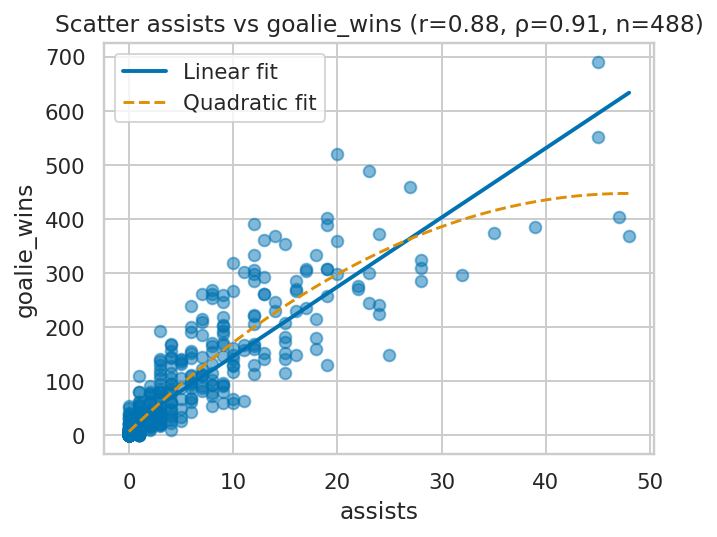

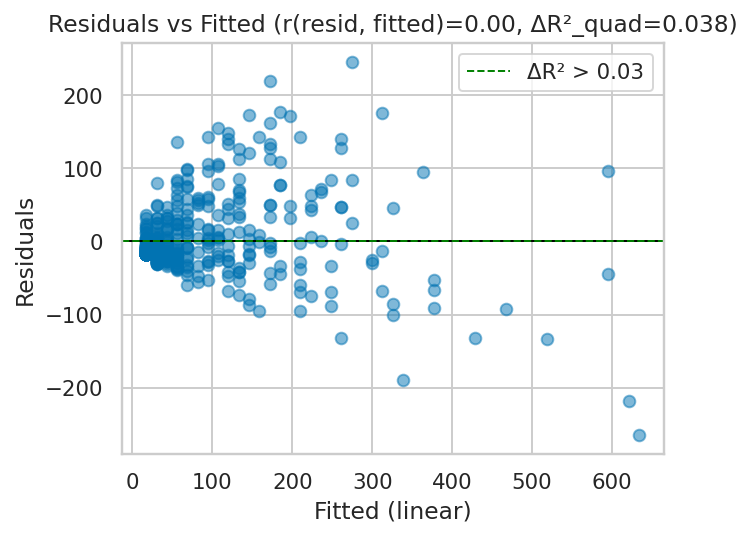

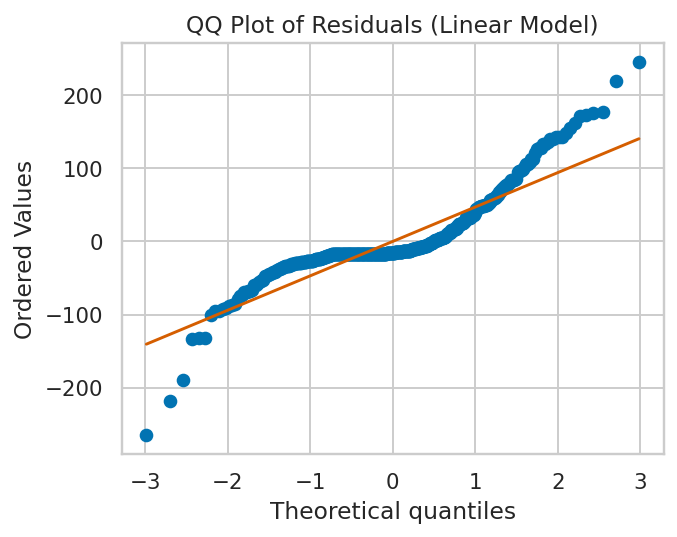

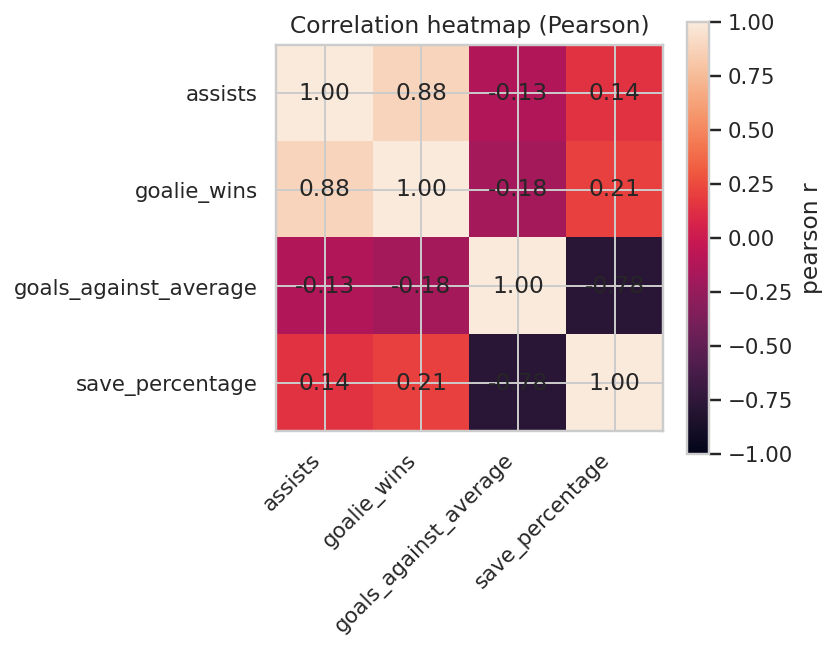

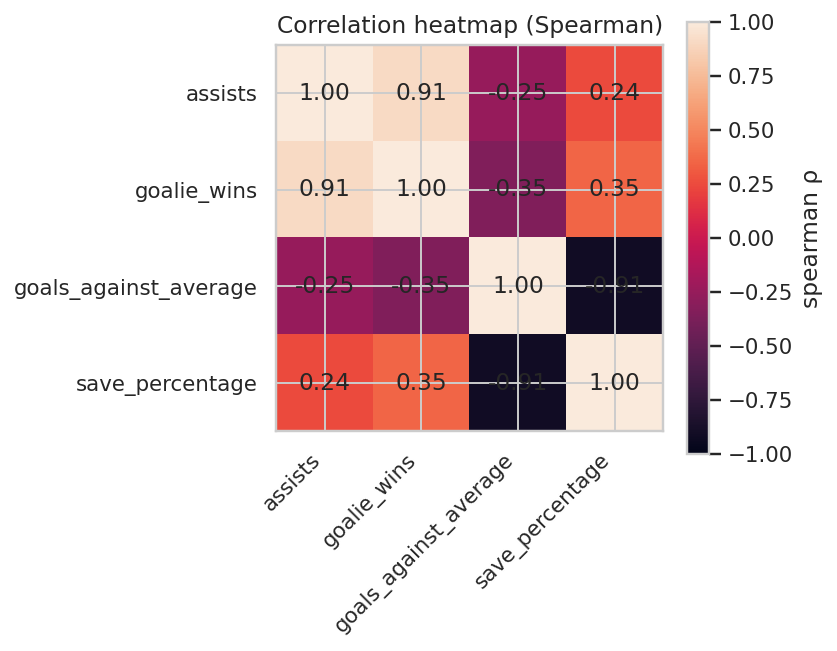

Recommendation: use **SPEARMAN**.  Stats: r=0.880 (p=3.45e-159), ρ=0.908 (p=4.86e-186).  Reasons: quadratic adds > 0.03 R² (nonlinearity)


{'recommendation': 'spearman',
 'n': 488,
 'pearson_r': np.float64(0.8799233006790181),
 'spearman_rho': np.float64(0.90826947464431),
 'pearson_p': np.float64(3.453190867964291e-159),
 'spearman_p': np.float64(4.856418304104057e-186),
 'resid_corr': np.float64(3.7404974950749903e-16),
 'delta_r2_quad': np.float64(0.03837564733132803),
 'reasons': ['quadratic adds > 0.03 R² (nonlinearity)']}

In [14]:
# Pre-correlation diagnostics (linear vs monotonic) — matplotlib-only
# Produces: (1) Scatter+LS, (2) Residuals vs Fitted, (3) Correlation heatmap
# Prints a Pearson vs Spearman recommendation.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional
from scipy.stats import pearsonr, spearmanr
from scipy.stats import probplot


def _simple_corr_heatmap(df: pd.DataFrame, cols: Optional[List[str]] = None, title: str = None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols = [c for c in cols if c in df.columns]
    if len(cols) < 2:
        print("[heatmap] Need at least 2 numeric columns.")
        return
    cmat = df[cols].corr(method="pearson")
    plt.figure(figsize=(6, 5), dpi=140)
    im = plt.imshow(cmat.values, vmin=-1, vmax=1)
    plt.colorbar(im, label="pearson r")
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)
    plt.title(title or "Correlation heatmap (Pearson)")
    for i in range(len(cols)):
        for j in range(len(cols)):
            v = cmat.values[i, j]
            if not np.isnan(v):
                plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()

def pre_correlation_analysis(df: pd.DataFrame, x: str, y: str, heatmap_cols: Optional[List[str]] = None, min_n: int = 30):
    sub = df[[x, y]].dropna()
    n = len(sub)
    if n < 3:
        print(f"[pre_correlation_analysis] Not enough data for plots: n={n}")
        return

    xv = sub[x].to_numpy()
    yv = sub[y].to_numpy()

    # (1) Scatter + least-squares line
    # (1) Scatter + least-squares line and optional quadratic
    plt.figure(figsize=(5, 4), dpi=140)
    plt.scatter(xv, yv, alpha=0.5)

    xs = np.linspace(np.nanmin(xv), np.nanmax(xv), 100)
    try:
        m, b = np.polyfit(xv, yv, 1)
        plt.plot(xs, m * xs + b, linewidth=2, label="Linear fit")
    except Exception as e:
        print(f"[scatter] Fit failed: {e}")
        m, b = np.nan, np.nan

    try:
        a2, a1, a0 = np.polyfit(xv, yv, 2)
        plt.plot(xs, a2 * xs**2 + a1 * xs + a0, linestyle="--", label="Quadratic fit")
    except Exception as e:
        print(f"[scatter] Quadratic fit failed: {e}")

    r, p = pearsonr(xv, yv)
    rho, ps = spearmanr(xv, yv)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"Scatter {x} vs {y} (r={r:.2f}, ρ={rho:.2f}, n={n})")
    plt.legend()
    plt.tight_layout(); plt.show()

    # (2) Residuals vs fitted from linear model
    if not np.isnan(m):
        yhat = m * xv + b
        resid = yv - yhat
        # pattern & nonlinearity checks
        r_res_fit = pearsonr(resid, yhat)[0] if n >= 3 else np.nan
        try:
            a2, a1, a0 = np.polyfit(xv, yv, 2)
            yhat2 = a2 * xv**2 + a1 * xv + a0
            sse1 = np.sum((yv - yhat)**2)
            sse2 = np.sum((yv - yhat2)**2)
            tss  = np.sum((yv - np.mean(yv))**2)
            r2_1 = 1 - sse1 / tss if tss > 0 else np.nan
            r2_2 = 1 - sse2 / tss if tss > 0 else np.nan
            delta_r2 = (r2_2 - r2_1) if (not np.isnan(r2_1) and not np.isnan(r2_2)) else np.nan
        except Exception:
            delta_r2 = np.nan
        plt.figure(figsize=(5, 4), dpi=140)
        plt.scatter(yhat, resid, alpha=0.5)
        plt.axhline(0, color="black", linewidth=1)

        # Optional annotation when thresholds crossed
        if abs(r_res_fit) > 0.2:
            plt.axhline(0, color="red", linestyle="--", linewidth=1, label="|resid-fitted| > 0.2")
        if delta_r2 > 0.03:
            plt.axhline(0, color="green", linestyle="--", linewidth=1, label="ΔR² > 0.03")

        plt.xlabel("Fitted (linear)"); plt.ylabel("Residuals")
        plt.title(f"Residuals vs Fitted (r(resid, fitted)={r_res_fit:.2f}, ΔR²_quad={0 if np.isnan(delta_r2) else delta_r2:.3f})")
        plt.legend()
        plt.tight_layout(); plt.show()

        ##qqplot
        plt.figure(figsize=(5, 4), dpi=140)
        probplot(resid, dist="norm", plot=plt)
        plt.title("QQ Plot of Residuals (Linear Model)")
        plt.tight_layout(); plt.show()

    else:
        r_res_fit = np.nan
        delta_r2 = np.nan

    # (3) Correlation heatmap (choose columns or default numeric)
    _simple_corr_heatmap(df, cols=heatmap_cols, title="Correlation heatmap (Pearson)")
    # (3b) Spearman correlation heatmap
    if heatmap_cols is None:
        heatmap_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    spearman_corr = df[heatmap_cols].corr(method="spearman")
    plt.figure(figsize=(6, 5), dpi=140)
    im = plt.imshow(spearman_corr.values, vmin=-1, vmax=1)
    plt.colorbar(im, label="spearman ρ")
    plt.xticks(range(len(heatmap_cols)), heatmap_cols, rotation=45, ha="right")
    plt.yticks(range(len(heatmap_cols)), heatmap_cols)
    plt.title("Correlation heatmap (Spearman)")
    for i in range(len(heatmap_cols)):
        for j in range(len(heatmap_cols)):
            v = spearman_corr.values[i, j]
            if not np.isnan(v):
                plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    plt.tight_layout(); plt.show()

    # Heuristic recommendation
    recommend = "pearson"
    reasons = []
    if not (np.isnan(rho) or np.isnan(r)) and (abs(rho) - abs(r) >= 0.10):
        recommend = "spearman"; reasons.append("|ρ| noticeably > |r| (≥ 0.10)")
    if not np.isnan(r_res_fit) and abs(r_res_fit) > 0.20:
        recommend = "spearman"; reasons.append("|corr(resid, fitted)| > 0.20 (pattern)")
    if not np.isnan(delta_r2) and delta_r2 > 0.03:
        recommend = "spearman"; reasons.append("quadratic adds > 0.03 R² (nonlinearity)")
    warn = " (low n)" if n < min_n else ""
    print(f"Recommendation: use **{recommend.upper()}**{warn}.  "
          f"Stats: r={r:.3f} (p={p:.3g}), ρ={rho:.3f} (p={ps:.3g}).  "
          f"Reasons: {', '.join(reasons) if reasons else 'linear looks ok'}")
    return {
    "recommendation": recommend,
    "n": n,
    "pearson_r": r,
    "spearman_rho": rho,
    "pearson_p": p,
    "spearman_p": ps,
    "resid_corr": r_res_fit,
    "delta_r2_quad": delta_r2,
    "reasons": reasons
}


pre_correlation_analysis(
    hockey_df,
    "assists",
    "goalie_wins",
    heatmap_cols=["assists","goalie_wins","goals_against_average","save_percentage"]
)


In [ ]:
# ===== Correlation & Association Harness for Hockey Data (Integrated) =====
# This version plugs in:
#  - Pearson+Spearman with "signaling"
#  - Scatter (dispersion) with LS fit
#  - Hexbin (with optional +1 bin)
#  - 2D Density (KDE) and Hexbin+KDE overlay
#  - Global correlation heatmap
#  - Pairwise contingency heatmap + chi-square table
#  - Category box plot (Y by binned X)
#
# Plotting: matplotlib only (no seaborn), one figure per chart, no explicit colors.
# Safe to execute: if `hockey_df` isn't defined, this only loads functions.
# ==========================================================================

import numpy as np
import pandas as pd
from itertools import combinations
from typing import List, Tuple, Optional
from scipy.stats import pearsonr, spearmanr, chi2_contingency, gaussian_kde
import matplotlib.pyplot as plt
# --- Fisher z comparison: Pearson vs Spearman (same x,y) ---
from scipy.stats import norm



# ---------- general helpers ----------

# --- Fisher z comparison: Pearson vs Spearman (same x,y) ---
from scipy.stats import norm

def fisher_z_compare(df: pd.DataFrame, x: str, y: str, n_boot: int = 1000, alpha: float = 0.05, seed: Optional[int] = 0):
    """
    Compare Pearson r and Spearman rho via Fisher z.
    Returns an approximate z-test (treating z(r) and z(rho) as independent; heuristic)
    AND a bootstrap confirmation on delta_z = atanh(r) - atanh(rho).
    """
    sub = df[[x, y]].dropna()
    n = len(sub)
    if n < 4:
        return {"note": "too_few_obs", "n": n}

    xv = sub[x].to_numpy(); yv = sub[y].to_numpy()
    r, _ = pearsonr(xv, yv)
    rho, _ = spearmanr(xv, yv)

    # clip to avoid atanh(±1)
    r = np.clip(r, -0.999999, 0.999999)
    rho = np.clip(rho, -0.999999, 0.999999)

    zr   = np.arctanh(r)
    zrho = np.arctanh(rho)
    delta_z = zr - zrho

    # --- Approx z test (heuristic): treat as independent (conservative/approx) ---
    se = 1.0 / np.sqrt(n - 3)
    se_diff = np.sqrt(2.0) * se
    z_stat_indep = delta_z / se_diff
    p_indep = 2 * (1 - norm.cdf(abs(z_stat_indep)))

    # --- Bootstrap confirmation on delta_z ---
    p_boot = np.nan; ci_lo = np.nan; ci_hi = np.nan
    if n_boot and n_boot > 0:
        rng = np.random.default_rng(seed)
        deltas = np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            idx = rng.integers(0, n, n)
            xb = xv[idx]; yb = yv[idx]
            rb  = np.clip(pearsonr(xb, yb)[0], -0.999999, 0.999999)
            rhob = np.clip(spearmanr(xb, yb)[0], -0.999999, 0.999999)
            deltas[i] = np.arctanh(rb) - np.arctanh(rhob)
        ci_lo, ci_hi = np.quantile(deltas, [alpha/2, 1 - alpha/2])
        # two-sided bootstrap p: how extreme the observed delta_z is vs bootstrap distribution
        p_boot = np.mean(np.abs(deltas - np.mean(deltas)) >= np.abs(delta_z))

    return {
        "n": n,
        "pearson_r": r, "spearman_rho": rho,
        "z_pearson": zr, "z_spearman": zrho,
        "delta_z": delta_z,
        "z_stat_indep": z_stat_indep, "p_indep": p_indep,
        "boot_ci_delta_z": (ci_lo, ci_hi), "p_boot": p_boot,
        "note": "z_indep is heuristic; bootstrap is robust"
    }


def to_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def to_pct01(s: pd.Series) -> pd.Series:
    s2 = s.astype(str).str.replace("%", "", regex=False)
    s2 = pd.to_numeric(s2, errors="coerce")
    if s2.dropna().median() > 1:  # detect 0–100 scale
        s2 = s2 / 100.0
    return s2

def ratio(num: pd.Series, den: pd.Series) -> pd.Series:
    return num / den.replace(0, np.nan)

def fisher_ci(r: float, n: int, z_crit: float = 1.96) -> Tuple[float, float]:
    if n <= 3 or np.isclose(abs(r), 1):
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return (lo, hi)


# ---------- correlation & "signaling" ----------

def corr_test(df: pd.DataFrame, x: str, y: str, min_n: int = 30, alpha: float = 0.05):
    sub = df[[x, y]].dropna()
    n = len(sub)
    if n < min_n:
        return {
            "var_a": x, "var_b": y, "n": n,
            "r": np.nan, "p": np.nan, "ci95_lo": np.nan, "ci95_hi": np.nan,
            "rho": np.nan, "p_s": np.nan, "signal": "too_few_obs"
        }
    r, p = pearsonr(sub[x], sub[y])
    lo, hi = fisher_ci(r, n)
    rho, p_s = spearmanr(sub[x], sub[y])

    ci_nonzero = (not np.isnan(lo)) and (not np.isnan(hi)) and (lo * hi > 0)
    strong_linear = (abs(r) >= 0.7) and (p < alpha) and (np.sign(r) == np.sign(rho)) and (p_s < alpha)
    signal = "✓ strong linear" if strong_linear else ("~ suggestive" if (p < alpha and ci_nonzero) else "× none")

    return {
        "var_a": x, "var_b": y, "n": n,
        "r": r, "p": p, "ci95_lo": lo, "ci95_hi": hi,
        "rho": rho, "p_s": p_s, "signal": signal
    }

def pairwise_corr(df: pd.DataFrame, cols: List[str], min_n: int = 30, alpha: float = 0.05) -> pd.DataFrame:
    rows = [corr_test(df, a, b, min_n=min_n, alpha=alpha) for a, b in combinations(cols, 2)]
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(by=["r", "p"], key=lambda s: s.abs() if s.name == "r" else s, ascending=[False, True])
    return out


# ---------- plotting (matplotlib only) ----------

def scatter_with_fit(df: pd.DataFrame, x: str, y: str, title: Optional[str] = None):
    sub = df[[x, y]].dropna()
    if sub.empty:
        print(f"[scatter_with_fit] No data for {x} vs {y}")
        return
    xv = sub[x].to_numpy(); yv = sub[y].to_numpy()

    plt.figure(figsize=(5, 4), dpi=140)
    plt.scatter(xv, yv, alpha=0.5)
    try:
        m, b = np.polyfit(xv, yv, 1)
        xs = np.linspace(np.nanmin(xv), np.nanmax(xv), 100)
        plt.plot(xs, m * xs + b, linewidth=2)
    except Exception as e:
        print(f"[scatter_with_fit] Fit failed: {e}")
    r, p = pearsonr(xv, yv) if len(sub) >= 2 else (np.nan, np.nan)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(title or f"{x} vs {y} (r={r:.2f}, p={p:.3g}, n={len(sub)})")
    plt.tight_layout()
    plt.show()

def hexbin_plot(df: pd.DataFrame, x: str, y: str, gridsize=30, title: Optional[str] = None, plus_one: bool = False):
    sub = df[[x, y]].dropna()
    if sub.empty:
        print(f"[hexbin_plot] No data for {x} vs {y}")
        return

    if plus_one:
        if isinstance(gridsize, int):
            gridsize = gridsize + 1
        else:
            try:
                gx, gy = gridsize
                gridsize = (gx + 1, gy + 1)
            except Exception:
                gridsize = 31

    plt.figure(figsize=(5, 4), dpi=140)
    hb = plt.hexbin(sub[x].to_numpy(), sub[y].to_numpy(), gridsize=gridsize, mincnt=1)
    plt.colorbar(hb, label="count")
    plt.xlabel(x); plt.ylabel(y)
    plt.title(title or f"Hexbin: {x} vs {y} (gridsize={gridsize})")
    plt.tight_layout()
    plt.show()

def density_kde2d_plot(df: pd.DataFrame, x: str, y: str, gridsize: int = 100, levels: int = 10, shaded: bool = True, title: str = None):
    sub = df[[x, y]].dropna()
    if sub.empty:
        print(f"[density_kde2d_plot] No data for {x} vs {y}")
        return
    xv = sub[x].to_numpy(); yv = sub[y].to_numpy()
    values = np.vstack([xv, yv])
    try:
        kde = gaussian_kde(values)
    except Exception as e:
        print(f"[density_kde2d_plot] KDE failed: {e}")
        return

    xmin, xmax = np.nanmin(xv), np.nanmax(xv)
    ymin, ymax = np.nanmin(yv), np.nanmax(yv)
    X, Y = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    plt.figure(figsize=(5, 4), dpi=140)
    if shaded:
        plt.contourf(X, Y, Z, levels=levels)
    else:
        plt.contour(X, Y, Z, levels=levels)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(title or f"2D Density (KDE): {x} vs {y}")
    plt.tight_layout()
    plt.show()

def hexbin_with_kde(df: pd.DataFrame, x: str, y: str, gridsize=30, kde_levels: int = 8, title: str = None, plus_one: bool = False):
    sub = df[[x, y]].dropna()
    if sub.empty:
        print(f"[hexbin_with_kde] No data for {x} vs {y}")
        return

    if plus_one:
        if isinstance(gridsize, int):
            gridsize = gridsize + 1
        else:
            try:
                gx, gy = gridsize
                gridsize = (gx + 1, gy + 1)
            except Exception:
                gridsize = 31

    xv = sub[x].to_numpy(); yv = sub[y].to_numpy()

    plt.figure(figsize=(5, 4), dpi=140)
    hb = plt.hexbin(xv, yv, gridsize=gridsize, mincnt=1)
    plt.colorbar(hb, label="count")
    try:
        kde = gaussian_kde(np.vstack([xv, yv]))
        xmin, xmax = np.nanmin(xv), np.nanmax(xv)
        ymin, ymax = np.nanmin(yv), np.nanmax(yv)
        X, Y = np.meshgrid(np.linspace(xmin, xmax, 120), np.linspace(ymin, ymax, 120))
        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        plt.contour(X, Y, Z, levels=kde_levels)
    except Exception as e:
        print(f"[hexbin_with_kde] KDE overlay skipped: {e}")

    plt.xlabel(x); plt.ylabel(y)
    plt.title(title or f"Hexbin + KDE: {x} vs {y} (gridsize={gridsize})")
    plt.tight_layout()
    plt.show()

def corr_heatmap(df: pd.DataFrame,
                 cols: Optional[List[str]] = None,
                 method: str = "pearson",
                 title: Optional[str] = None,
                 annotate: bool = True,
                 tick_fs: int = 8,
                 ann_fs: int = 7):
    """
    Correlation heatmap (matplotlib-only) with controllable font sizes
    and auto figure size to reduce label overlap.
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols = [c for c in cols if c in df.columns]
    if len(cols) < 2:
        print("[corr_heatmap] Need at least 2 columns.")
        return

    cmat = df[cols].corr(method=method)

    # auto-size: scale with matrix dimension to avoid crowding
    k = len(cols)
    W = max(5, 0.45 * k + 1)   # width
    H = max(4, 0.45 * k + 1)   # height

    plt.figure(figsize=(W, H), dpi=140)
    im = plt.imshow(cmat.values, vmin=-1, vmax=1, aspect="equal")  # default cmap, centered scale
    plt.colorbar(im, label=f"{method} correlation")
    plt.xticks(range(k), cols, rotation=45, ha="right", fontsize=tick_fs)
    plt.yticks(range(k), cols, fontsize=tick_fs)
    plt.title(title or f"Correlation heatmap ({method})")
    if annotate:
        for i in range(k):
            for j in range(k):
                v = cmat.values[i, j]
                if not np.isnan(v):
                    plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=ann_fs)
    plt.tight_layout()
    plt.show()
    return cmat


def contingency_heatmap(df: pd.DataFrame, a: str, b: str, q: int = 4, title: Optional[str] = None,
                        show_counts: bool = True):
    if a not in df.columns or b not in df.columns:
        print(f"[contingency_heatmap] Missing columns: {a} or {b}")
        return pd.DataFrame()

    sub = df[[a, b]].dropna()
    if sub.empty:
        print("[contingency_heatmap] No data after dropping NaNs.")
        return pd.DataFrame()

    def bin_if_num(s: pd.Series):
        if pd.api.types.is_numeric_dtype(s.dropna()):
            try:
                return pd.qcut(s, q=q, duplicates="drop")
            except Exception:
                return pd.cut(s, bins=q)
        return s.astype("category")

    A = bin_if_num(sub[a]); B = bin_if_num(sub[b])
    ct = pd.crosstab(A, B, dropna=False)

    plt.figure(figsize=(6, 5), dpi=140)
    im = plt.imshow(ct.values)
    plt.colorbar(im, label="count")
    plt.xticks(range(ct.shape[1]), [str(c) for c in ct.columns], rotation=30, ha="right")
    plt.yticks(range(ct.shape[0]), [str(i) for i in ct.index])
    plt.title(title or f"Contingency heatmap: {a} × {b}")
    if show_counts:
        for i in range(ct.shape[0]):
            for j in range(ct.shape[1]):
                plt.text(j, i, f"{ct.values[i, j]}", ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return ct

def contingency_table(df: pd.DataFrame, a: str, b: str, q: int = 4) -> Tuple[pd.DataFrame, dict]:
    def bin_if_numeric(s: pd.Series):
        if pd.api.types.is_numeric_dtype(s.dropna()):
            try:
                return pd.qcut(s, q=q, duplicates="drop")
            except Exception:
                return pd.cut(s, bins=q)
        return s.astype("category")

    sub = df[[a, b]].dropna()
    if sub.empty:
        return pd.DataFrame(), {"note": "no_data"}

    A = bin_if_numeric(sub[a]); B = bin_if_numeric(sub[b])
    ct = pd.crosstab(A, B, dropna=False)
    chi2, p, dof, _ = chi2_contingency(ct) if ct.size > 0 else (np.nan, np.nan, np.nan, None)
    stats = {"chi2": chi2, "p": p, "dof": dof, "n": int(ct.values.sum())}
    return ct, stats

def box_by_binned_x(df: pd.DataFrame, x_num: str, y_num: str, q: int = 4):
    sub = df[[x_num, y_num]].dropna()
    if sub.empty:
        print(f"[box_by_binned_x] No data for {x_num} vs {y_num}")
        return
    try:
        cats = pd.qcut(sub[x_num], q=q, duplicates="drop")
    except Exception:
        cats = pd.cut(sub[x_num], bins=q)
    groups = [sub[y_num][cats == c].to_numpy() for c in cats.cat.categories]

    plt.figure(figsize=(6, 4), dpi=140)
    plt.boxplot(groups, showmeans=True)
    plt.xticks(range(1, len(groups)+1), [str(c) for c in cats.cat.categories], rotation=30, ha="right")
    plt.xlabel(f"{x_num} (binned)"); plt.ylabel(y_num)
    plt.title(f"{y_num} by {x_num} bins")
    plt.tight_layout()
    plt.show()


# ---------- domain-aware prep ----------

def prep_hockey(df: pd.DataFrame, filter_goalies: bool = True) -> pd.DataFrame:
    df = df.copy()
    sv_candidates = ["save_percentage", "sv%", "SV%", "goal_percentage"]
    sv_col = next((c for c in sv_candidates if c in df.columns), None)

    numeric_cols = [
        "assists", "points", "goals", "shots_against",
        "penalties_minutes", "goals_against_average",
        "goalie_games_played", "goalie_wins", "goalie_losses", "goalie_ties_overtime",
        "point_shares", "overall_pick"
    ]
    to_numeric(df, [c for c in numeric_cols if c in df.columns])
    if sv_col:
        df[sv_col] = to_pct01(df[sv_col])

    if filter_goalies:
        if "position" in df.columns:
            df = df[df["position"].astype(str).str.upper() == "G"]
        elif "goalie_games_played" in df.columns:
            df = df[df["goalie_games_played"].fillna(0) > 0]

    if {"goalie_wins", "goalie_losses", "goalie_ties_overtime"}.issubset(df.columns):
        df["decisions"] = df[["goalie_wins", "goalie_losses", "goalie_ties_overtime"]].fillna(0).sum(axis=1)
        df["wins_pct"] = ratio(df["goalie_wins"], df["decisions"])

    if {"penalties_minutes", "goalie_games_played"}.issubset(df.columns):
        df["pim_per_game"] = ratio(df["penalties_minutes"], df["goalie_games_played"])

    if {"point_shares", "goalie_games_played"}.issubset(df.columns):
        df["point_shares_per82"] = ratio(df["point_shares"], df["goalie_games_played"]) * 82

    return df


# ---------- public API ----------

def run_pair_suite(df: pd.DataFrame, pairs: List[Tuple[str, str]], min_n: int = 30, alpha: float = 0.05):
    """
    Given explicit (x,y) pairs, compute correlation table and render visuals.
    Includes:
      - Global correlation heatmap
      - Pairwise: scatter, hexbin(+KDE), contingency heatmap, chi-square table, box plot
    """
    dfp = prep_hockey(df, filter_goalies=True)

    present = [(x, y) for (x, y) in pairs if (x in dfp.columns and y in dfp.columns)]
    if not present:
        print("[run_pair_suite] None of the requested pairs are present in the data.")
        return

    # Correlation table with signaling
    rows = [corr_test(dfp, x, y, min_n=min_n, alpha=alpha) for (x, y) in present]
    out = pd.DataFrame(rows).sort_values(by=["r", "p"], key=lambda s: s.abs() if s.name == "r" else s, ascending=[False, True])
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Correlation (Pearson/Spearman) with signaling", out)
    except Exception:
        print(out.to_string(index=False))

    # Visuals for the first pair
    x0, y0 = present[0]
    # Fisher z: Pearson vs Spearman on the same (x0, y0)
    cmp = fisher_z_compare(dfp, x0, y0, n_boot=1000, alpha=0.05, seed=0)
    print(cmp.get("note"),'here----------------------------------------------------->')
    if cmp.get("note") != "too_few_obs":
        print(
            f"Pearson vs Spearman (Fisher z) for {x0}~{y0}: "
            f"delta_z={cmp['delta_z']:.3f}, z≈{cmp['z_stat_indep']:.2f}, "
            f"p_indep≈{cmp['p_indep']:.3g}, p_boot≈{cmp['p_boot']:.3g}, "
            f"CI_boot[{cmp['boot_ci_delta_z'][0]:.3f},{cmp['boot_ci_delta_z'][1]:.3f}], n={cmp['n']}"
        )


    scatter_with_fit(dfp, x0, y0, title=f"Scatter: {x0} vs {y0}")
    hexbin_with_kde(dfp, x0, y0, gridsize=30, kde_levels=8, title=f"Hexbin+KDE: {x0} vs {y0}", plus_one=True)

    # Global correlation heatmap across useful numeric features
    # Global correlation heatmaps across useful numeric features
    heat_candidates = [
        "assists", "points", "goals", "shots_against",
        "penalties_minutes", "goals_against_average",
        "goalie_wins", "goalie_losses",
        "pim_per_game", "wins_pct", "point_shares_per82",
        "overall_pick", "save_percentage", "sv%", "SV%", "goal_percentage"
    ]
    heat_cols = [c for c in heat_candidates if c in dfp.columns]
    if len(heat_cols) >= 2:
        corr_heatmap(dfp, heat_cols, method="pearson",
                    title="Correlation heatmap (Pearson)", tick_fs=7, ann_fs=6)
        corr_heatmap(dfp, heat_cols, method="spearman",
                    title="Correlation heatmap (Spearman)", tick_fs=7, ann_fs=6)

    # Pair-wise contingency heatmap (binned)
    contingency_heatmap(dfp, x0, y0, q=4, title=f"Contingency heatmap: {x0} × {y0}")

    # Contingency table + chi-square
    ct, stats = contingency_table(dfp, x0, y0, q=4)
    if not ct.empty:
        try:
            from caas_jupyter_tools import display_dataframe_to_user
            display_dataframe_to_user(f"Contingency table ({x0} bins × {y0} bins)", ct)
        except Exception:
            print(ct)
        print(f"Chi-square = {stats['chi2']:.3f}, p = {stats['p']:.3g}, dof = {stats['dof']}, n = {stats['n']}")

    # Category box plot
    box_by_binned_x(dfp, x0, y0, q=4)


def run_correlation_study(df: pd.DataFrame, filter_goalies: bool = True, min_n: int = 30, alpha: float = 0.05):
    """
    Auto-select useful pairs around goalie outcomes and run the suite.
    """
    dfp = prep_hockey(df, filter_goalies=filter_goalies)

    sv_candidates = [c for c in ["save_percentage", "sv%", "SV%", "goal_percentage"] if c in dfp.columns]
    sv_col = sv_candidates[0] if sv_candidates else None

    wishlist = [
        ("assists", "goalie_wins"),
        ("penalties_minutes", "goalie_losses"),
        ("penalties_minutes", "goalie_wins"),
        (sv_col, "goalie_wins") if sv_col else None,
        ("goals_against_average", "goalie_wins"),
        ("shots_against", sv_col) if sv_col and "shots_against" in dfp.columns else None,
        ("goals_against_average", sv_col) if sv_col else None,
        ("points", sv_col) if sv_col and "points" in dfp.columns else None,
        ("pim_per_game", "goalie_wins") if "pim_per_game" in dfp.columns else None,
        ("wins_pct", sv_col) if sv_col and "wins_pct" in dfp.columns else None,
        ("overall_pick", "goalie_wins") if "overall_pick" in dfp.columns else None,
    ]

    # Robust build: ignore None entries, check presence
    pairs = []
    for pair in wishlist:
        if pair is None:
            continue
        a, b = pair
        if a in dfp.columns and b in dfp.columns:
            pairs.append((a, b))

    if not pairs:
        print("[run_correlation_study] Could not find the expected columns to form pairs.")
        return

    run_pair_suite(dfp, pairs, min_n=min_n, alpha=alpha)


# -------------------- Demo guard --------------------
if "hockey_df" in globals():
    print("Functions loaded. To run:\n"
          "  run_correlation_study(hockey_df, filter_goalies=True, min_n=30, alpha=0.05)\n"
          "or explicit pairs:\n"
          "  run_pair_suite(hockey_df, [(\"assists\",\"goalie_wins\"), (\"penalties_minutes\",\"goalie_losses\")])")
else:
    print("Functions loaded. Define `hockey_df`, then call:\n"
          "  run_correlation_study(hockey_df)\n"
          "or:\n"
          "  run_pair_suite(hockey_df, [(\"assists\",\"goalie_wins\"), (\"penalties_minutes\",\"goalie_losses\")])")


Functions loaded. To run:
  run_correlation_study(hockey_df, filter_goalies=True, min_n=30, alpha=0.05)
or explicit pairs:
  run_pair_suite(hockey_df, [("assists","goalie_wins"), ("penalties_minutes","goalie_losses")])


                var_a           var_b   n         r             p   ci95_lo   ci95_hi       rho           p_s          signal
              assists     goalie_wins 488  0.879923 3.453191e-159  0.858188  0.898509  0.908269 4.856418e-186 ✓ strong linear
goals_against_average save_percentage 488 -0.777116 8.539282e-100 -0.810006 -0.739352 -0.908081 7.800868e-186 ✓ strong linear
    penalties_minutes   goalie_losses 488  0.644468  1.275255e-58  0.589422  0.693557  0.877808 1.833525e-157    ~ suggestive
    penalties_minutes     goalie_wins 488  0.629798  2.734513e-55  0.573071  0.680520  0.859594 8.068058e-144    ~ suggestive
             wins_pct save_percentage 444  0.468504  1.317488e-25  0.392557  0.538106  0.516037  1.393232e-31    ~ suggestive
      save_percentage     goalie_wins 486  0.206679  4.342292e-06  0.119937  0.290290  0.354247  8.145623e-16    ~ suggestive
goals_against_average     goalie_wins 488 -0.184726  4.031761e-05 -0.269079 -0.097561 -0.346094  3.535317e-15    ~ sug

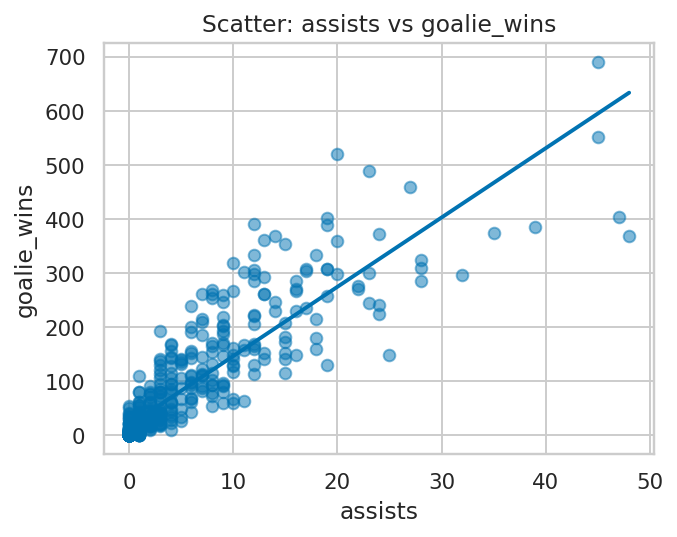

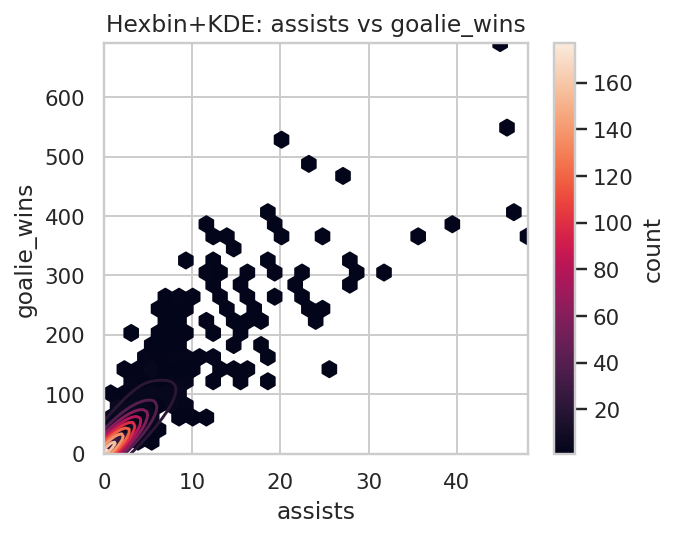

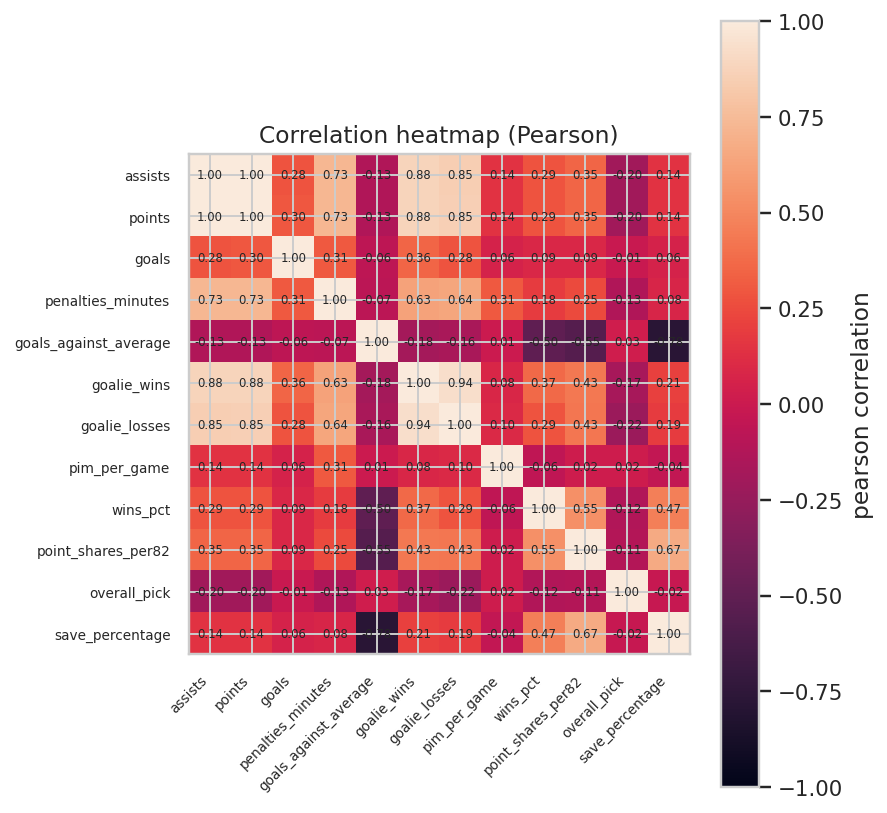

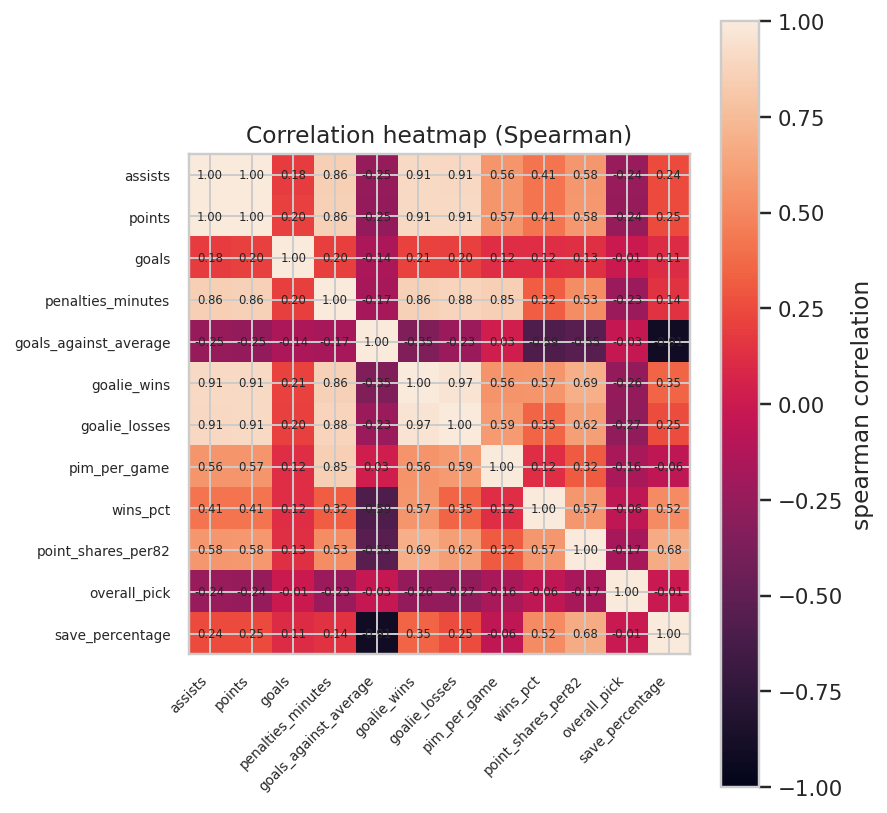

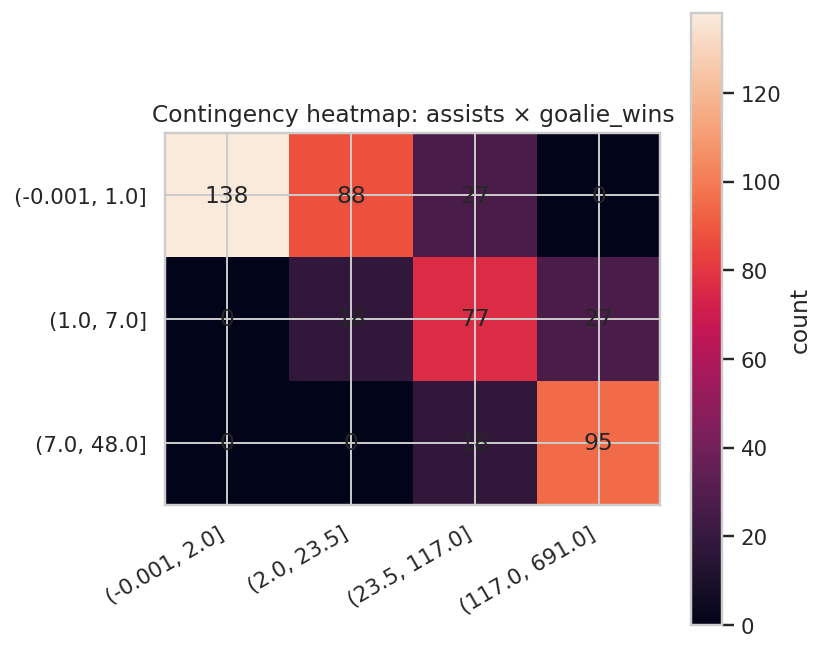

goalie_wins    (-0.001, 2.0]  (2.0, 23.5]  (23.5, 117.0]  (117.0, 691.0]
assists                                                                 
(-0.001, 1.0]            138           88             27               0
(1.0, 7.0]                 0           18             77              27
(7.0, 48.0]                0            0             18              95
Chi-square = 492.083, p = 4.27e-103, dof = 6, n = 488


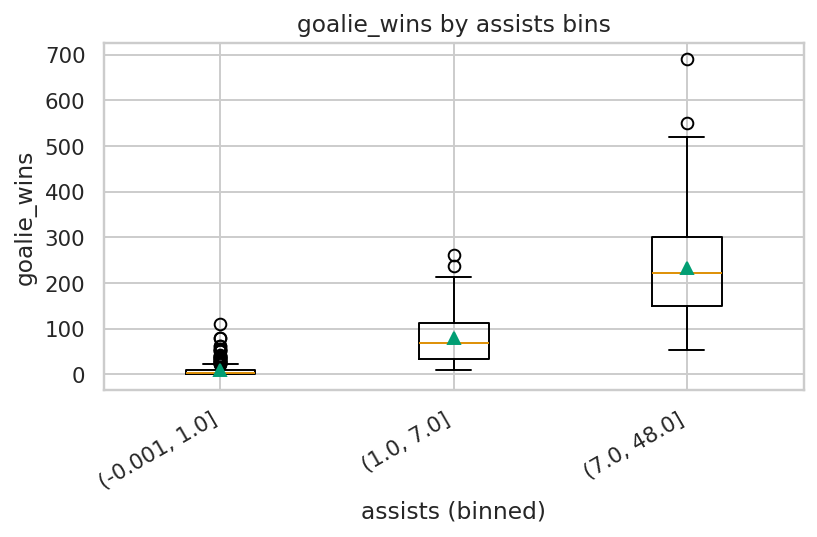

            var_a         var_b   n        r             p  ci95_lo  ci95_hi      rho           p_s          signal
          assists   goalie_wins 488 0.879923 3.453191e-159 0.858188 0.898509 0.908269 4.856418e-186 ✓ strong linear
penalties_minutes goalie_losses 488 0.644468  1.275255e-58 0.589422 0.693557 0.877808 1.833525e-157    ~ suggestive
z_indep is heuristic; bootstrap is robust here----------------------------------------------------->
Pearson vs Spearman (Fisher z) for assists~goalie_wins: delta_z=-0.142, z≈-2.21, p_indep≈0.0269, p_boot≈0.052, CI_boot[-0.269,0.019], n=488


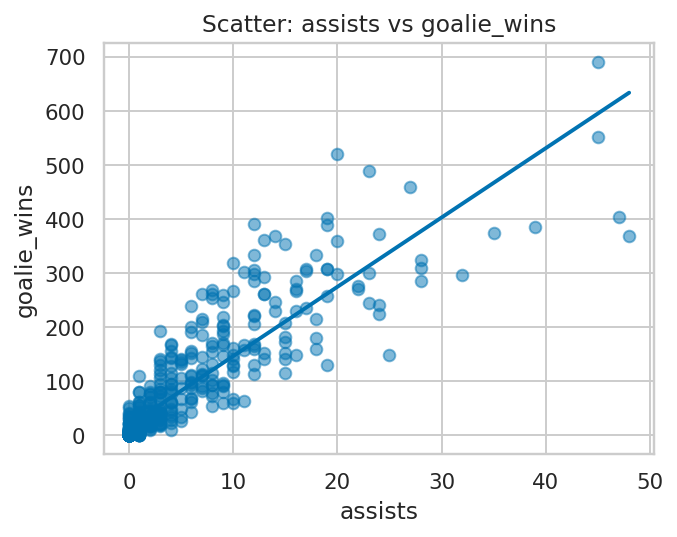

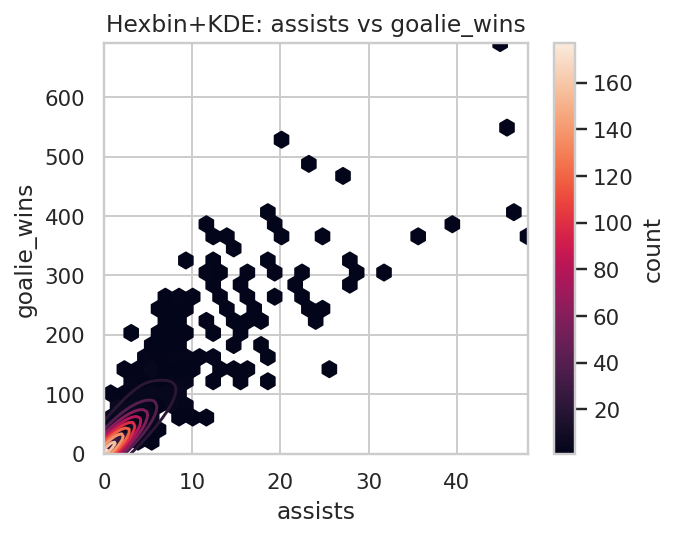

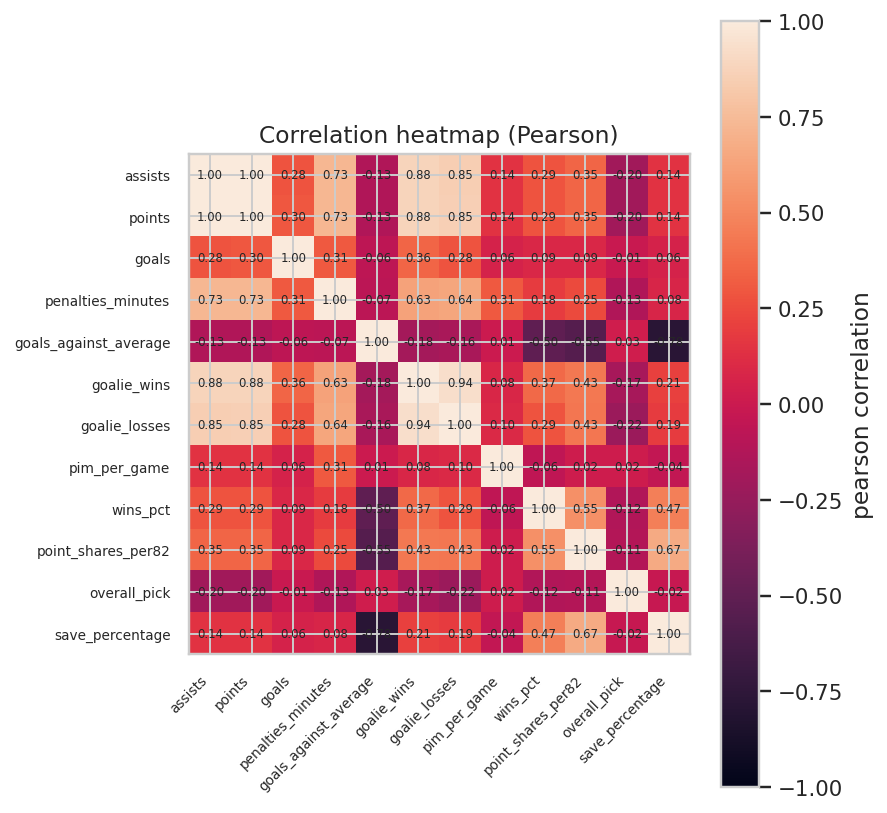

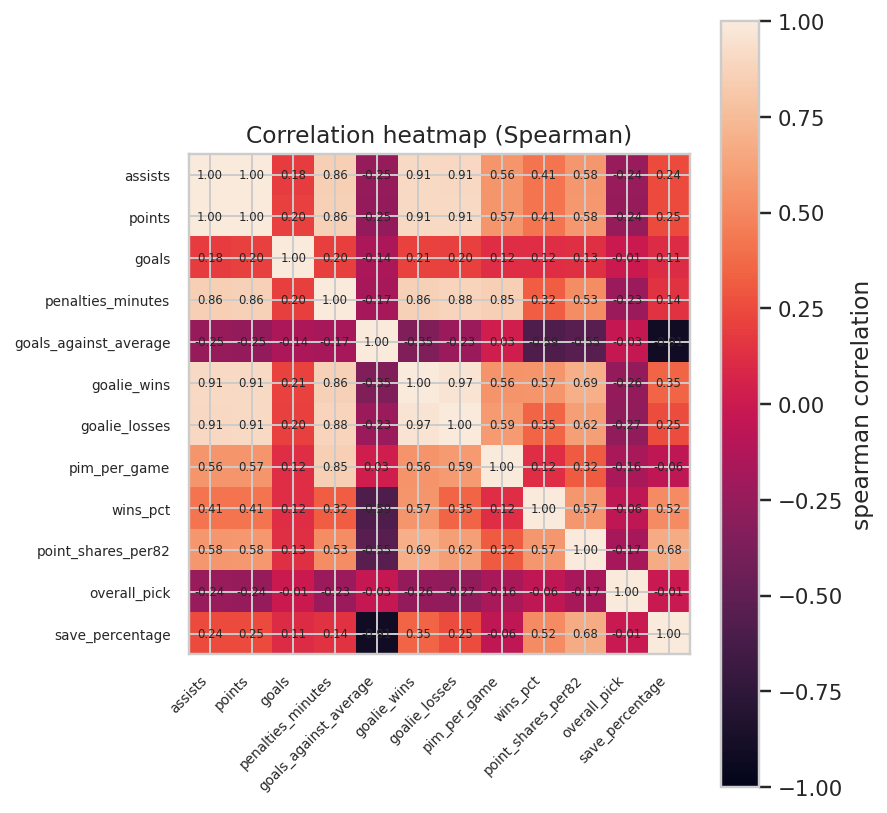

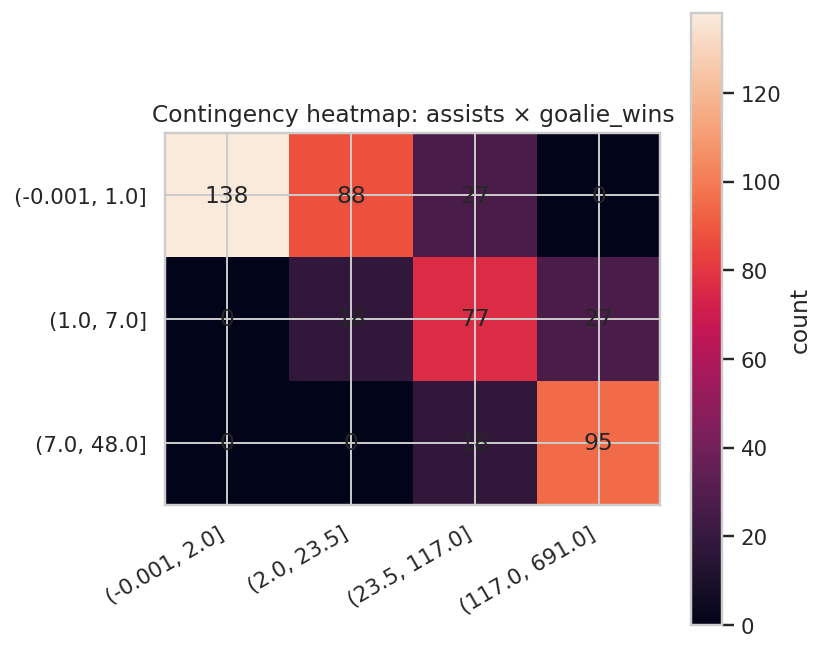

goalie_wins    (-0.001, 2.0]  (2.0, 23.5]  (23.5, 117.0]  (117.0, 691.0]
assists                                                                 
(-0.001, 1.0]            138           88             27               0
(1.0, 7.0]                 0           18             77              27
(7.0, 48.0]                0            0             18              95
Chi-square = 492.083, p = 4.27e-103, dof = 6, n = 488


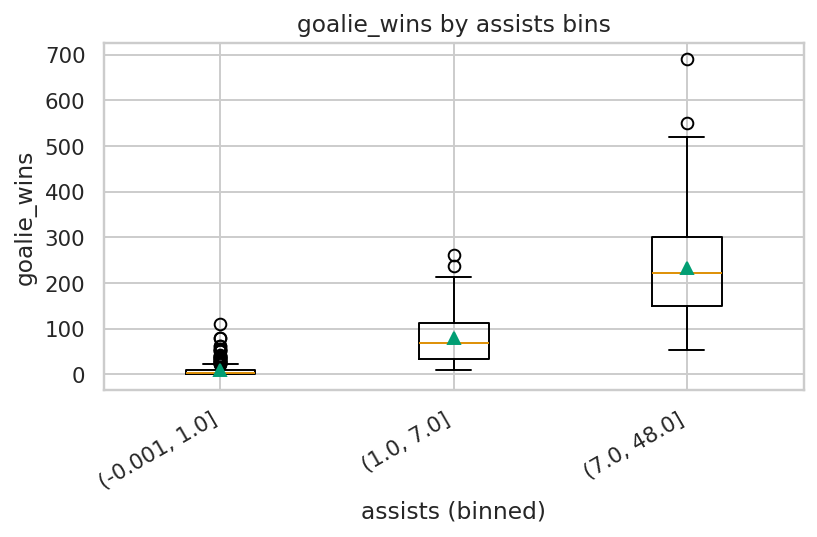

In [ ]:
# auto driver (goalie-focused)
run_correlation_study(hockey_df, filter_goalies=True, min_n=30, alpha=0.05)

# or pick exact pairs
run_pair_suite(hockey_df, [("assists","goalie_wins"),
                           ("penalties_minutes","goalie_losses")])


In [ ]:
hockey_df.columns

Index(['id', 'year', 'overall_pick', 'team', 'player', 'nationality',
       'position', 'age', 'to_year', 'amateur_team', 'games_played', 'goals',
       'assists', 'points', 'plus_minus', 'penalties_minutes',
       'goalie_games_played', 'goalie_wins', 'goalie_losses',
       'goalie_ties_overtime', 'save_percentage', 'goals_against_average',
       'point_shares'],
      dtype='object')